# Predict `Subject Age`

In [189]:
%matplotlib inline

In [238]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path

In [191]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [192]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [193]:
phenotype = 'Gender'

In [194]:
#load data
aging_dir = Path('/home/ubuntu/a/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


In [195]:
print(samples[phenotype].describe())
counts = samples[phenotype].value_counts()
print(counts)

count        260
unique         2
top       Female
freq         147
Name: Gender, dtype: object
Female    147
Male      113
Name: Gender, dtype: int64


In [196]:
##### Step 3: split train, validation and test######
x = []
y = []
dic = {"Male" : 0, "Female" : 1}
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(dic[row[phenotype]])
#age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
print(y_raw)
# age_min = min(y_raw)
# age_max = max(y_raw)
# age_range = age_max - age_min
# y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y_raw)
x_train.shape

[1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1
 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0
 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0
 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1
 1]


(195, 5000, 27, 1)

In [197]:
print(x[0].shape)

(5000, 27, 1)


In [256]:

model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(4, kernel_size = (1, x.shape[2]), activation="relu"),
    BatchNormalization(),
    Conv2D(8, kernel_size = (1,1), activation="relu"),
    BatchNormalization(),
    Conv2D(8, kernel_size = (1,1), activation="relu"),
    BatchNormalization(),
    Conv2D(16, kernel_size = (1,1), activation="relu"),
    BatchNormalization(),
    #Activation('relu'),
#     GlobalAveragePooling2D(),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
#     Dense(16, activation=None),
#     BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
#     Input(shape=x[0].shape),
#     Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(6, kernel_size = (1,1), activation=None),
#     BatchNormalization(),
#     Activation('relu'),
#     AveragePooling2D(pool_size = (x.shape[1], 1)),
#     Flatten(),
#     Dense(3, activation=None),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(1, activation=None),
# ])
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 5000, 1, 4)        112       
_________________________________________________________________
batch_normalization_237 (Bat (None, 5000, 1, 4)        16        
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 5000, 1, 8)        40        
_________________________________________________________________
batch_normalization_238 (Bat (None, 5000, 1, 8)        32        
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 5000, 1, 8)        72        
_________________________________________________________________
batch_normalization_239 (Bat (None, 5000, 1, 8)        32        
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 5000, 1, 16)     

In [257]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_accuracy', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
#           batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 0.7011 - accuracy: 0.5163 - val_loss: 0.6888 - val_accuracy: 0.5846
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6913 - accuracy: 0.5121 - val_loss: 0.6885 - val_accuracy: 0.5846
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6814 - accuracy: 0.5616 - val_loss: 0.6881 - val_accuracy: 0.5846
Epoch 4/200
7/7 [==============================] - 0s 19ms/step - loss: 0.6715 - accuracy: 0.5983 - val_loss: 0.6870 - val_accuracy: 0.5538
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 0.6571 - accuracy: 0.6054 - val_loss: 0.6859 - val_accuracy: 0.5846
Epoch 6/200
7/7 [==============================] - 0s 18ms/step - loss: 0.6728 - accuracy: 0.5680 - val_loss: 0.6836 - val_accuracy: 0.5692
Epoch 7/200
7/7 [==============================] - 0s 18ms/step - loss: 0.6589 - accuracy: 0.5898 - val_loss: 0.6806 - val_accuracy: 0.5846
Epoch 8/200
7/7 [===

In [200]:
# np.set_printoptions(precision=4, suppress=True)
# eval_results = model.evaluate(x_valid, y_valid, verbose=0) 
# print("\nLoss, accuracy on test data: ")
# print("%0.4f %0.2f%%" % (eval_results[0], \
#   eval_results[1]*100))


Loss, accuracy on test data: 
0.6126 67.69%


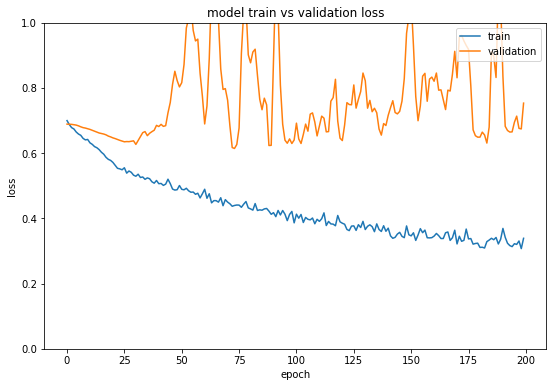

In [258]:
##### Step 6: plot train and validation loss #####
history = model.history
# plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
# plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.plot(pd.Series(history.history['loss']))
plt.plot(pd.Series(history.history['val_loss']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.ylim([0,1])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

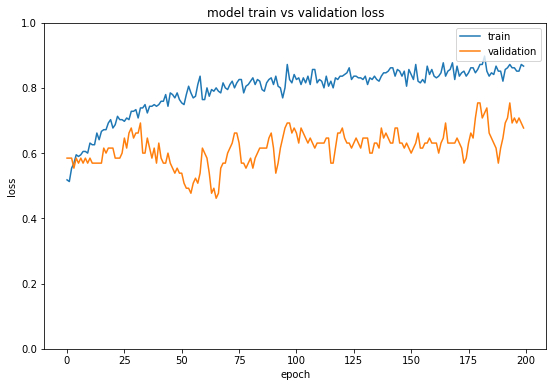

In [259]:
##### Step 6: plot train and validation loss #####
history = model.history
# plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
# plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.plot(pd.Series(history.history['accuracy']))
plt.plot(pd.Series(history.history['val_accuracy']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.ylim([0,1])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [66]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])


In [59]:
errors = (pd.Series(y_test)-pd.Series(y_scores))
errors.describe()

count    65.000000
mean      0.177777
std       0.493102
min      -0.378711
25%      -0.378711
50%       0.621289
75%       0.621289
max       0.729993
dtype: float64

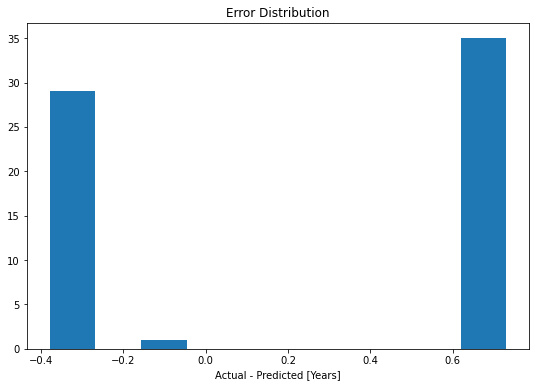

In [60]:
plt.hist(errors)
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

In [234]:
age_true = y_test*age_range + age_min
age_pred = y_scores*age_range + age_min
plt.plot(age_true, age_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(age_true, age_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()

NameError: name 'y_test' is not defined

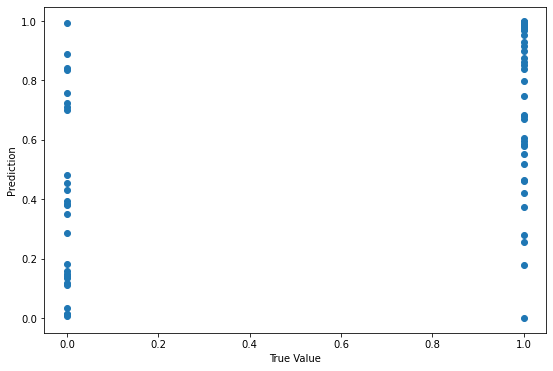

In [260]:

#### Test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
plt.scatter(y_valid, y_scores)
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()


Accuracy: 0.7538461538461538



<ipython-input-261-caf7df9fb7c0>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Male', 'Female'])
<ipython-input-261-caf7df9fb7c0>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Male', 'Female'])


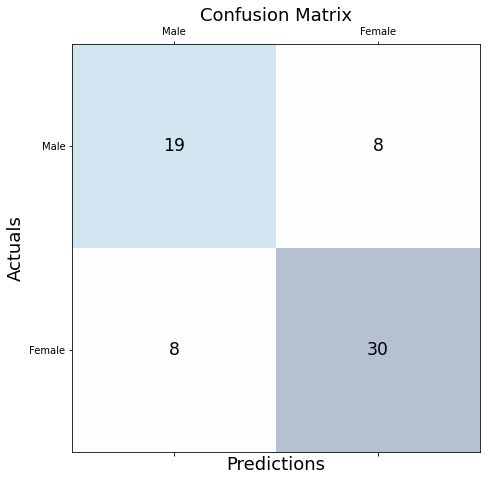

In [261]:
y_scores = np.rint(y_scores).astype(int)
cm = confusion_matrix(y_valid, y_scores)  

print ("")
print ("Accuracy: " + str((cm[0,0] + cm[1,1]) / sum(sum(cm))))
print ("")

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
ax.set_xticklabels(['', 'Male', 'Female'])
ax.set_yticklabels(['', 'Male', 'Female'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

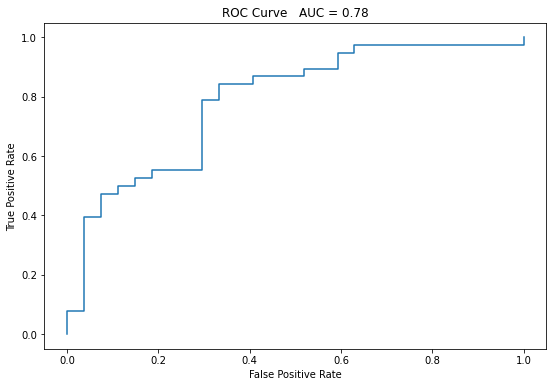

In [262]:
# generate ROC and AUC
y_scores = final_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
#plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve   AUC = {0:.2f}'.format(roc_auc))
plt.show()